### Connecting to the drive to access the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing necessary libraries

In [ ]:
import warnings
import numpy as np
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
from PIL import ImageEnhance
import cv2

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay,f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD

### Unzipping the Data folder

In [ ]:
import zipfile

# Unzipping the images
#zip_ref = zipfile.ZipFile("/content/drive/MyDrive/AI_project/images.zip", 'r')
#zip_ref.extractall("/content/drive/MyDrive/AI_project/")
#zip_ref.close()

### Getting the paths to the Data folders

In [ ]:
import os

# The path to the images folder on google drive
path = '/content/drive/MyDrive/AI_project/eye-images'

normal = os.path.join(path,'1_normal/')
cataract = os.path.join(path,'2_cataract/')
glaucoma = os.path.join(path,'2_glaucoma/')
print("Number of Normal eye dataset", len(os.listdir(normal)))
print("Number of Cataract dataset", len(os.listdir(cataract)))
print("Number of Glaucoma dataset", len(os.listdir(glaucoma)))


Number of Normal eye dataset 300
Number of Cataract dataset 100
Number of Glaucoma dataset 101


## ***Data Exploration***

## Visualising the class distribution using a Pie-chart

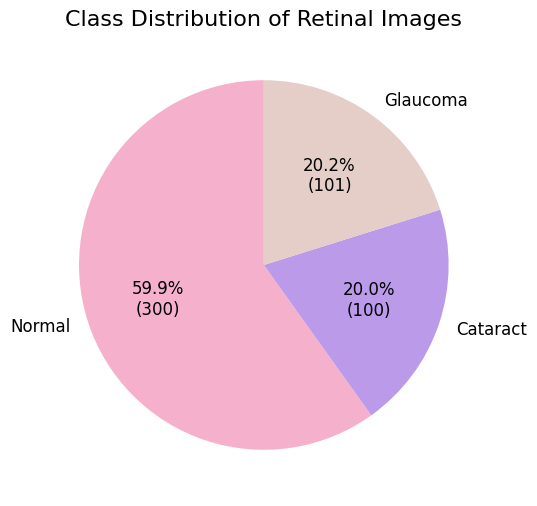

In [ ]:
import matplotlib.pyplot as plt

# Class distribution data
classes = ['Normal', 'Cataract', 'Glaucoma']
values = [300, 100, 101]  # Number of images in each class
total = sum(values)

# Generate the pie chart
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    values,
    labels=classes,
    autopct=lambda p: f'{p:.1f}%\n({round(p * total / 100)})',  # Add percentage and value
    colors=['#F5B0CB', '#BA9AE9', '#E4CEC7'],  # Custom colors
    startangle=90,
    textprops={'fontsize': 12}  # Font size for text
)

# Improve the display of labels
for text in texts + autotexts:
    text.set_color('black')

# Add title
plt.title('Class Distribution of Retinal Images', fontsize=16)

# Show the pie chart
plt.show()


In [ ]:
## Load the file names from all directories
normal_images = os.listdir(normal)
cataract_images =  os.listdir(cataract)
glaucoma_images =  os.listdir(glaucoma)

This function displays a specified number of images from a given directory in a grid format for better visualization. It is particularly useful when working with large datasets containing multiple classes, as it eliminates the need to repeatedly write the plotting function.

In [ ]:
import math

def display_images(directory, image_list, num_images, title="Images", images_per_row=5):
    """
    Displays a specified number of images from a given directory in rows for better viewing.

    Parameters:
    - directory (str): Path to the directory containing images.
    - image_list (list): List of image file names in the directory.
    - num_images (int): Number of images to display.
    - title (str): Title for the displayed images (default: "Images").
    - images_per_row (int): Number of images to display per row (default: 5).

    Returns:
    - None
    """
    # Validate the number of images
    if num_images > len(image_list):
        raise ValueError(f"Requested {num_images} images, but only {len(image_list)} are available.")

    # Calculate the number of rows needed
    num_rows = math.ceil(num_images / images_per_row)

    # Plot the images
    plt.figure(figsize=(images_per_row * 3, num_rows * 3))  # Adjust the figure size dynamically
    for i, image_name in enumerate(image_list[:num_images]):
        img_path = os.path.join(directory, image_name)
        img = Image.open(img_path)

        # Determine subplot position
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(img)
        plt.title(f"{title} {i + 1}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

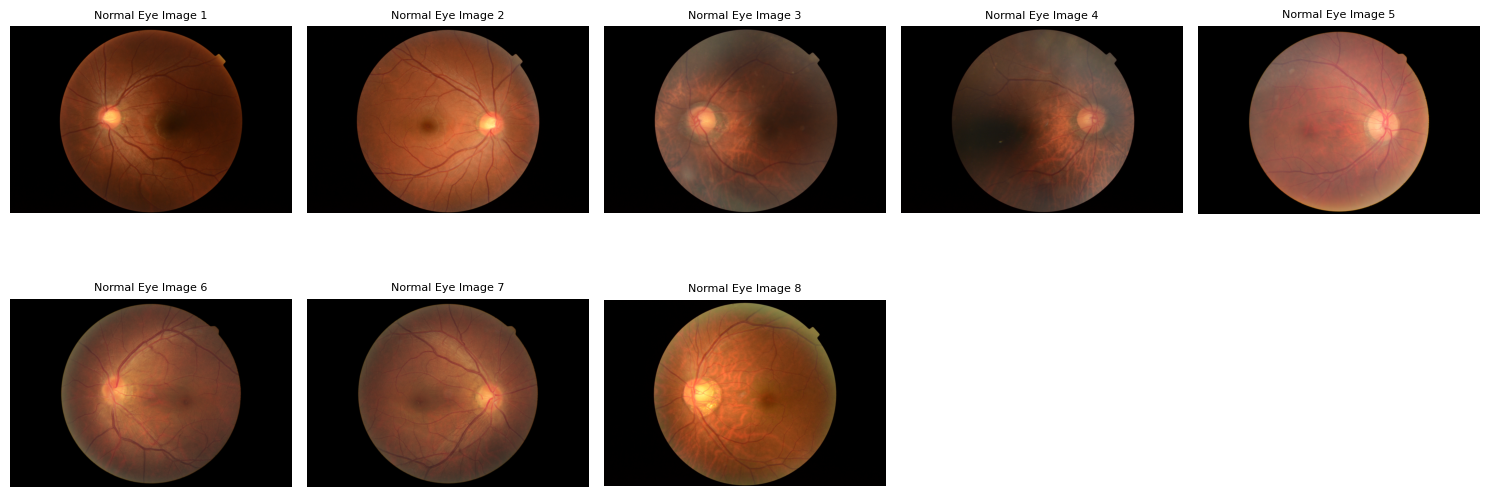

In [ ]:
display_images(normal,
               normal_images,
               num_images=8,
               title="Normal Eye Image")

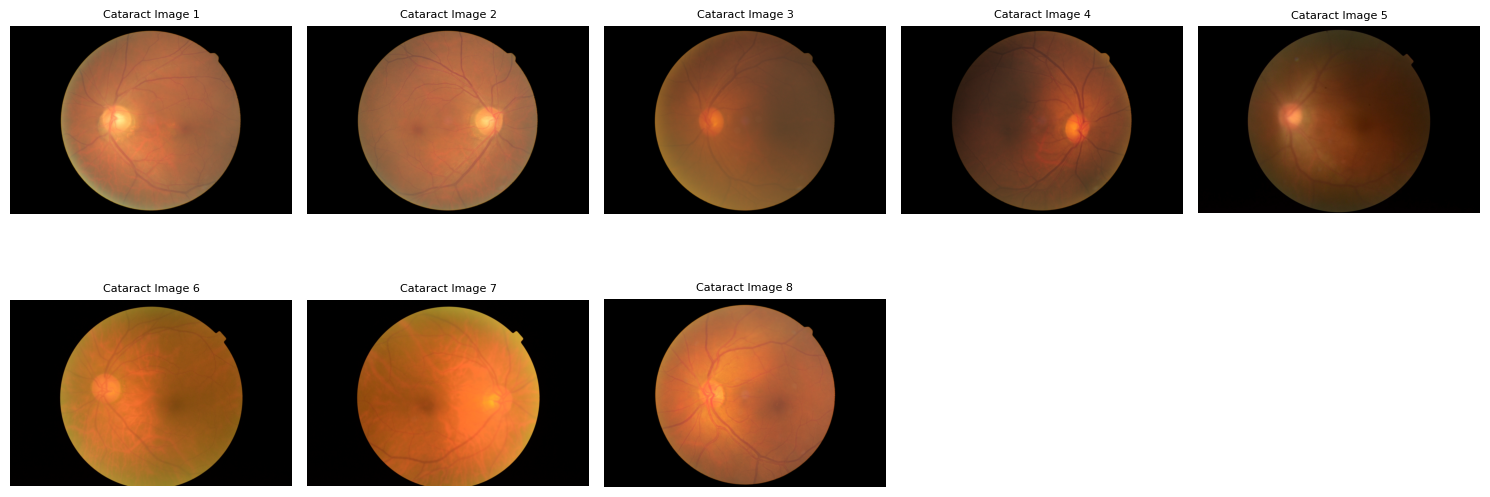

In [ ]:
display_images(cataract,
               cataract_images,
               num_images=8,
               title="Cataract Image")

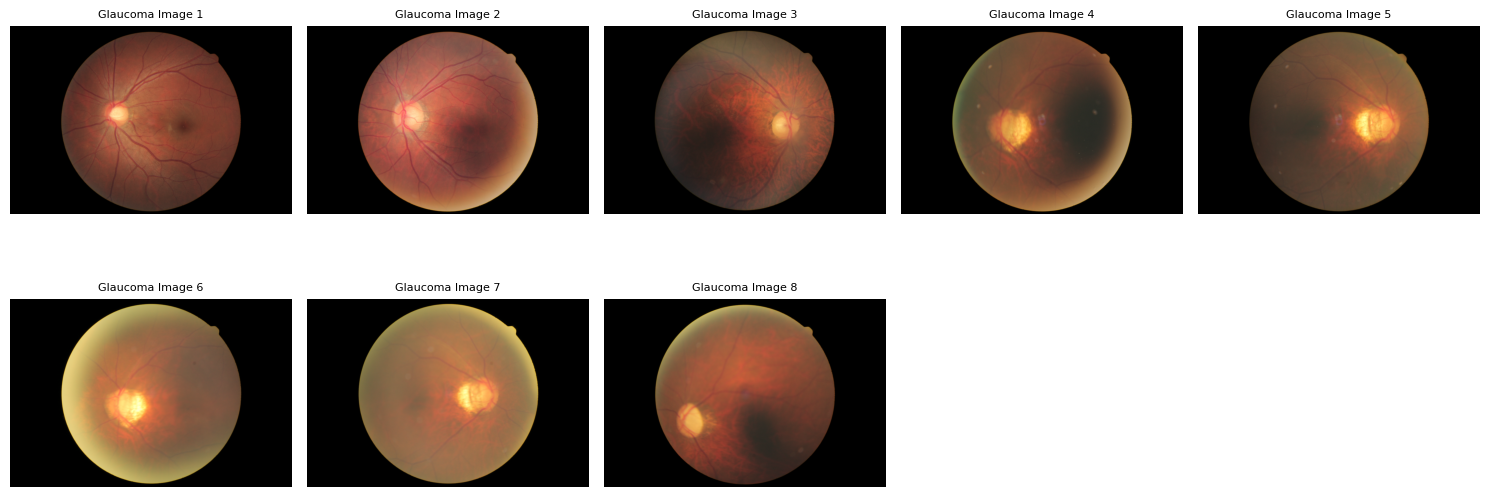

In [ ]:
display_images(glaucoma,
               glaucoma_images,
               num_images=8,
               title="Glaucoma Image")

In [ ]:
# Getting the image size
import cv2
img = cv2.imread('/content/drive/MyDrive/AI_project/eye-images/1_normal/NL_001.png')
img.shape

(1632, 2464, 3)

# ***Quality Control***

The following code chunk verifies the image integrity using the the Pillow package and provides flexibility to choose between sequential and parallel processing. Sequential processing is simple and suitable for small datasets, while parallel processing accelerates the validation of large datasets by utilizing multiple threads. Users can toggle between these options using a parameter, optimizing the process based on dataset size and system resources.

In [ ]:
from concurrent.futures import ThreadPoolExecutor

# This function accepts the path to a single file and checks if its corrupt or not
def is_image_corrupt(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the integrity of the image
        return None  # return None if image is valid
    except Exception:
        return file_path  # If corrupt, return file path

# This function allows the validation of images in a folder by sequential or parallel processing methods
def find_corrupt_images(image_dir, use_parallel=True, max_workers=4):

    # Collect all image files in the directory
    image_files = [
        os.path.join(image_dir, file)
        for file in os.listdir(image_dir)
        if file.lower().endswith(('.png', '.jpeg'))
    ]

    if use_parallel:
        # Parallel processing using ThreadPoolExecutor
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            corrupt_files = list(filter(None, executor.map(is_image_corrupt, image_files)))
    else:
        # Sequential processing
        corrupt_files = [file for file in image_files if is_image_corrupt(file)]

    return corrupt_files

# To remove corrupt files from the ML pipeline, if any
def remove_corrupt_images(image_dir, corrupt_files):
    for corrupt_file in corrupt_files:
        os.remove(corrupt_file)  # Remove the corrupt file
        print(f"Removed corrupted file: {corrupt_file}")

Checking for corrupted files in the image folders

In [ ]:
folders = [normal, cataract, glaucoma]

for folder in folders:
    folder_name = os.path.basename(os.path.normpath(folder))
    print(f"Checking for corrupted files in {folder_name}...")

    # Using sequential image validation as the dataset is small.
    corrupt_files = find_corrupt_images(folder, use_parallel=False)

    if corrupt_files:
        print(f"Corrupted files in {folder_name}:")
        print("\n".join(corrupt_files))
        remove_corrupt_images(folder, corrupt_files)
    else:
        print(f"No corrupted files found in {folder_name}.")
    print("-" * 50)


Checking for corrupted files in 1_normal...
No corrupted files found in 1_normal.
--------------------------------------------------
Checking for corrupted files in 2_cataract...
No corrupted files found in 2_cataract.
--------------------------------------------------
Checking for corrupted files in 2_glaucoma...
No corrupted files found in 2_glaucoma.
--------------------------------------------------


The following code chunk provides functions to analyze image quality based on various metrics, including sharpness (FFT-based blur detection), brightness, contrast, and noise estimation. It supports batch processing of images from a directory with an option for parallel execution to speed up large dataset analysis.


In [ ]:
import cv2
import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor

# Function for FFT-based blur detection
def fft_blur_metric(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)  # Shift the zero frequency component to the center
    magnitude_spectrum = np.abs(fshift)
    return np.mean(magnitude_spectrum)  # Higher mean = sharper image

# Function for image quality analysis
def analyze_image_quality2(file_path):
    try:
        img_gray = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        img_color = cv2.imread(file_path)

        if img_gray is None or img_color is None:
            return file_path, "Unreadable Image"


        # Sharpness (FFT-based Blur Detection)
        fft_sharpness = fft_blur_metric(img_gray)

        # Brightness (Mean pixel intensity in grayscale)
        brightness = np.mean(img_gray)

        # Contrast (RMS contrast)
        gray_mean = np.mean(img_gray)
        rms_contrast = np.sqrt(np.mean((img_gray - gray_mean) ** 2))

        # Noise Estimation (Median Absolute Deviation)
        median = np.median(img_gray)
        mad = np.median(np.abs(img_gray - median))

        # Defining thresholds. These must be adjust based on medical imaging context.
        fft_blur_threshold = 150
        brightness_low = 25
        brightness_high = 200
        contrast_threshold = 20
        noise_threshold = 10

        # Identifying image quality issues based on the set thresholds
        issues = []
        if fft_sharpness < fft_blur_threshold:
            issues.append("Blurry")
        if brightness < brightness_low or brightness > brightness_high:
            issues.append("Brightness Issue")
        if rms_contrast < contrast_threshold:
            issues.append("Low Contrast")
        if mad > noise_threshold:
            issues.append("High Noise")

        return file_path, ", ".join(issues) if issues else []  # Return empty list if no issues

    except Exception as e:
        return file_path, f"Error: {str(e)}"

# Function to check image quality in a directory
def check_image_quality2(image_dir, use_parallel=True, max_workers=4):
    image_files = [
        os.path.join(image_dir, file)
        for file in os.listdir(image_dir)
        if file.lower().endswith(('.png', '.jpeg', '.jpg', '.bmp'))
    ]

    quality_issues = []

    if use_parallel:
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            results = list(executor.map(analyze_image_quality2, image_files))
            for file, issues in results:
                if issues:
                    quality_issues.append((file, issues))
    else:
        for file in image_files:
            file_issues = analyze_image_quality2(file)
            if file_issues[1]:
                quality_issues.append(file_issues)

    return quality_issues


In [ ]:
folders = [normal, cataract, glaucoma]
#folders = [normal]

for folder in folders:
    folder_name = os.path.basename(os.path.normpath(folder))
    print(f"Checking image quality in {folder_name}...")

    quality_issues = check_image_quality2(folder, use_parallel=True)

    if quality_issues:
        print(f"Low-quality images in {folder_name}:")
        for file, problem in quality_issues:
            print(f"{file} - {problem}")

        # Move bad images to a separate folder
        #move_low_quality_images(folder, quality_issues, output_dir="low_quality_images")
    else:
        print(f"All images in {folder_name} passed quality checks!")

    print("-" * 50)


Checking image quality in 1_normal...
Low-quality images in 1_normal:
/content/drive/MyDrive/AI_project/eye-images/1_normal/NL_287.png - Brightness Issue
--------------------------------------------------
Checking image quality in 2_cataract...
Low-quality images in 2_cataract:
/content/drive/MyDrive/AI_project/eye-images/2_cataract/cataract_020.png - Brightness Issue
--------------------------------------------------
Checking image quality in 2_glaucoma...
All images in 2_glaucoma passed quality checks!
--------------------------------------------------


### Data Augmentation

To introduce variability in the dataset to help the models generalize better.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomBrightness, GaussianNoise, Rescaling, Resizing

augmentation = Sequential([

    Input(shape=(224, 224, 3)),
    RandomFlip("horizontal"),  # horizontal flips for anatomical realism
    RandomBrightness(factor=0.1),
    RandomRotation((-0.025, 0.025)),  # Small rotations to simulate slight capture variations
    RandomZoom(0.05),  # Minor zoom variations
    RandomTranslation(0.025, 0.025),  # Handle slight misalignments
    GaussianNoise(0.05),  # Add subtle noise for robustness
    Rescaling(1./255)  # Normalize pixel values to [0, 1]

])

In [ ]:
augmentation.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_brightness (RandomBrightness) │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

(1, 224, 224, 3)


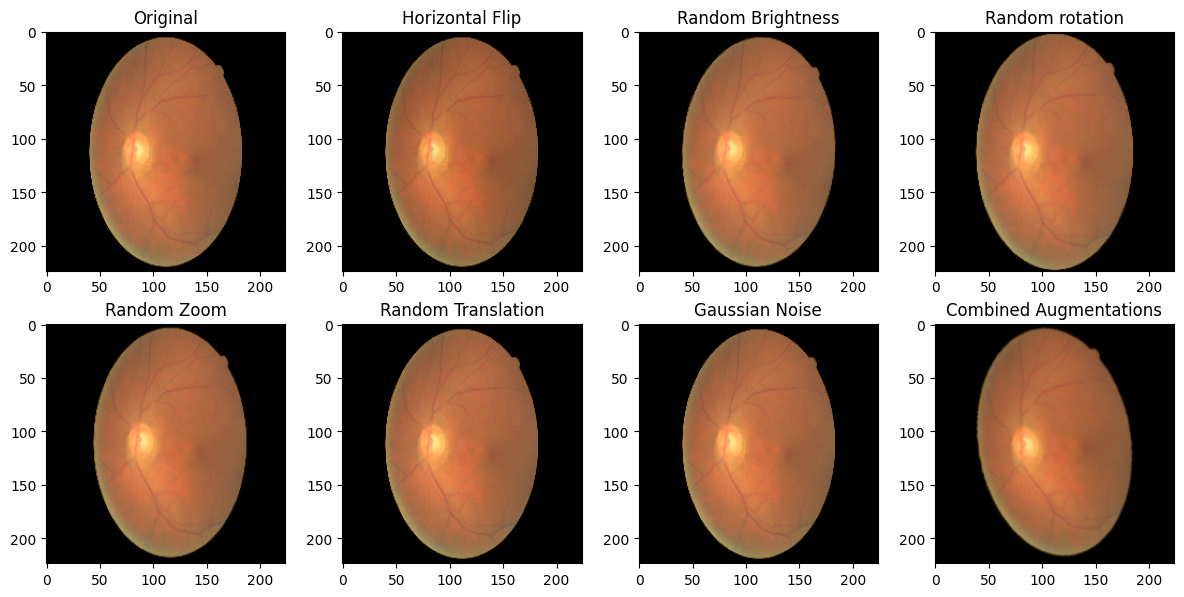

In [ ]:
# Load a sample image to test the augmentation steps -> must avoid distortions
img = tf.keras.preprocessing.image.load_img(os.path.join(cataract, cataract_images[0]), target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
print(img_array.shape)

# Apply each augmentation step individually and visualize
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()

# Original image
axs[0].imshow(img)
axs[0].set_title('Original')

# Random Flip - horizontal
augmented_img = augmentation.layers[1](img_array) # Applying RandomFlip using index 1
axs[1].imshow(tf.squeeze(augmented_img)/255.0)
axs[1].set_title('Horizontal Flip')

# Random Flip - vertical
augmented_img = augmentation.layers[2](img_array) # Applying Random Brightness using index 2
axs[2].imshow(tf.squeeze(augmented_img)/255.0)
axs[2].set_title('Random Brightness')

# Random Rotation
augmented_img = augmentation.layers[3](img_array) # Applying Random rotation using index 3
axs[3].imshow(tf.squeeze(augmented_img)/255.0)
axs[3].set_title('Random rotation')

# Random Zoom
augmented_img = augmentation.layers[4](img_array) # Applying RandomZoom using index 4
axs[4].imshow(tf.squeeze(augmented_img)/255.0)
axs[4].set_title('Random Zoom')

# Random Transalation
augmented_img = augmentation.layers[5](img_array) # Applying Random Translation using index 5
axs[5].imshow(tf.squeeze(augmented_img)/255.0)
axs[5].set_title('Random Translation')

# Gaussion Noise
augmented_img = augmentation.layers[6](img_array) # Applying Gaussian using index 6
axs[6].imshow(tf.squeeze(augmented_img))
axs[6].set_title('Gaussian Noise')

# Combined Augmentations
augmented_img = augmentation(img_array)
axs[7].imshow(tf.squeeze(augmented_img))
axs[7].set_title('Combined Augmentations')

# Show the plot
plt.tight_layout()
plt.show()

## Image Preprocessing

In [ ]:
import cv2  # used to read images

# Note - it resizes all images to 100x100

def load_images(directories, n_images=900000):
    """
    Reads in images and assigns class labels
    Parameters:
        directories: A list of the sub-directories
        n_images:    The maximum number of images to load from each directory
    Returns:
        images (numpy.ndarray) : Image data
        label (numpy.ndarray      : Labels of each image
    """
    images = []
    labels = []
    for label, sub_dir in enumerate(directories):
        num=1
        for file_name in os.listdir(sub_dir):
            if num > n_images:
                break
            img_path = os.path.join(sub_dir, file_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Resize to a smaller, consistent shape
                #gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                #images.append(gray_image)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(label)
                num+=1
    return np.array(images), np.array(labels)

In [ ]:
images, labels = load_images([normal, cataract, glaucoma])

In [ ]:
images.shape

(501, 224, 224, 3)

## Splitting the data for training the model

In [ ]:
# Import required package
from sklearn.model_selection import train_test_split

# Spliting data into training + validation and test set (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Further spliting training + validation into training and validation sets (e.g., 75% train, 25% val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.20, random_state=42
)

# Convert labels to categorical for training, validation, and test sets
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=3)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [ ]:
from collections import Counter

print(Counter(y_train))
print(Counter(y_test))

Counter({0: 190, 1: 67, 2: 63})
Counter({0: 53, 2: 28, 1: 20})


## CNN Architecture

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)

cnn_model2 = models.Sequential([
    Input(shape=(224, 224, 3)),
    augmentation,
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten and Fully Connected Layer
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(3, activation='softmax')
])

In [ ]:
# Compiling the model with Adam optimizer
optimizer = Adam(learning_rate=1e-4) # Default value

cnn_model2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  # for multi-class classification
              metrics=['accuracy', 'categorical_accuracy'])

# Summary of the model
cnn_model2.summary()

## Adding weights to classes/categories to account for Imbalanced dataset

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
class_weights_dict

{0: 0.5614035087719298, 1: 1.592039800995025, 2: 1.693121693121693}

### Training the model with class weights

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = cnn_model2.fit(
    X_train,  # Input data
    y_train_cat,  # Categorical labels
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    #callbacks = [early_stopping],
    class_weight=class_weights_dict
)

In [ ]:
# Using the model to make predictions on the testset
y_pred_prob = cnn_model2.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [ ]:
y_pred  = y_pred_prob.argmax(axis=1)

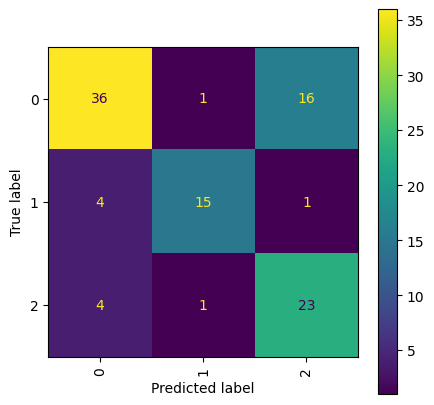

In [ ]:
cm  = confusion_matrix(y_test, y_pred)
cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
cmdisp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")
plt.show()

In [ ]:
from sklearn.metrics  import classification_report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.68      0.74        53
           1       0.88      0.75      0.81        20
           2       0.57      0.82      0.68        28

    accuracy                           0.73       101
   macro avg       0.76      0.75      0.74       101
weighted avg       0.76      0.73      0.74       101



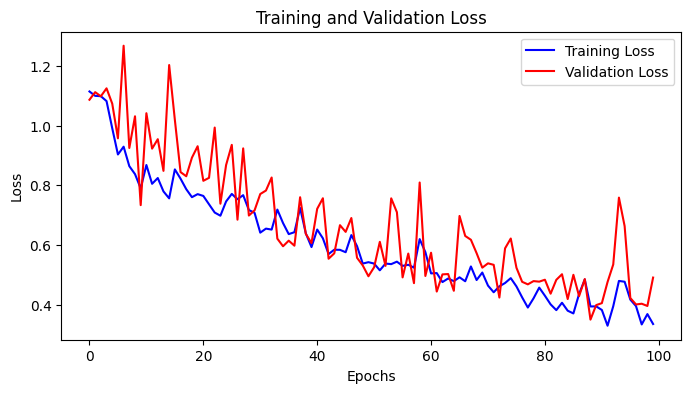

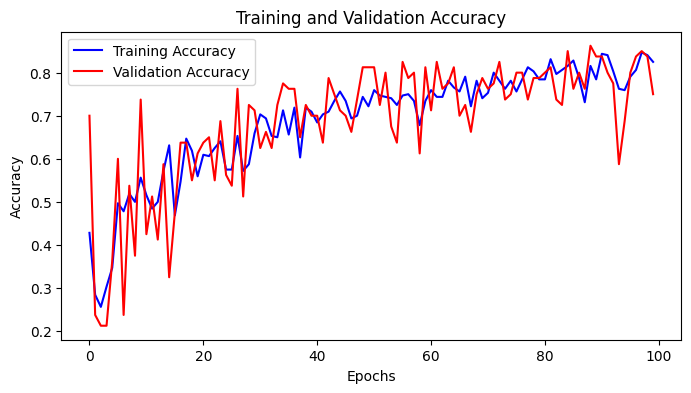

In [ ]:
epochs = history.epoch
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The training and the validation accuracy and loss fluctuate over the training epochs. However, there are no signs of overfitting.

In [ ]:
from sklearn.metrics import roc_curve, auc

n_classes = y_test_cat.shape[1]  # Number of classes
n_classes

3

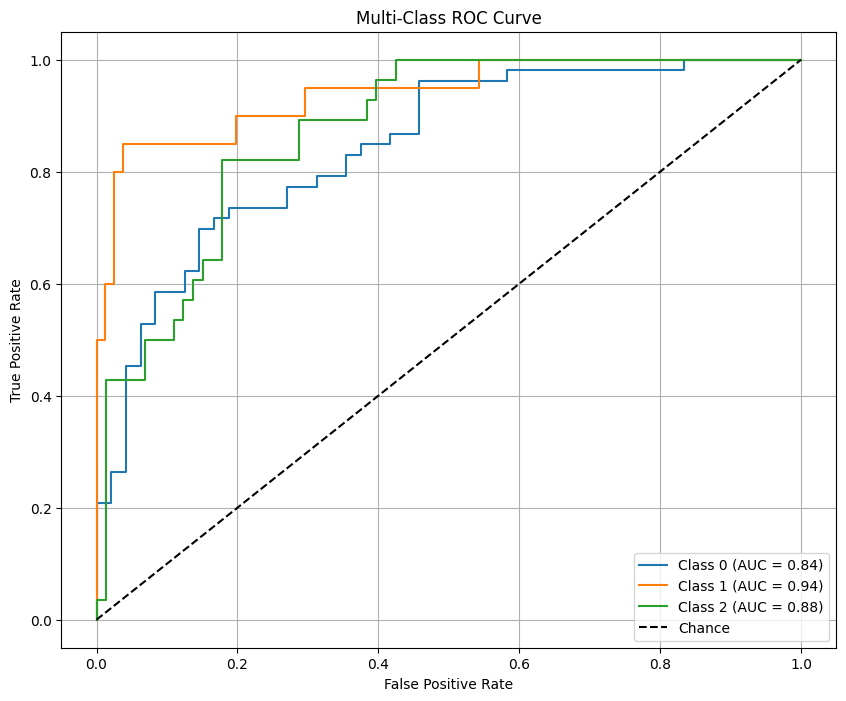

In [ ]:
# Initialize plot
plt.figure(figsize=(10, 8))

# Loop through each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])  # Compute FPR and TPR
    roc_auc = auc(fpr, tpr)  # Compute AUC

    # Plot ROC curve for the current class
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the "chance" line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

# Add labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# Save the model in the newer Keras format
cnn_model2.save("/content/drive/MyDrive/AI_project/Models/cnn_classifier2_with_class_weights.keras")
cnn_model2.save_weights("/content/drive/MyDrive/AI_project/Models/cnn_classifier2.weights.h5")

### Attempting to improve the model performance

The precision and recall for class 2 (glaucoma) is poor compared to the other classes. This section attempts to adjust the CNN architecture and the class weights to mitigate this.

In [ ]:
from tensorflow.keras.regularizers import l2

# Changed the pooling from 2x2 to 3x3
cnn_model2b = models.Sequential([
    Input(shape=(224, 224, 3)),
    augmentation,
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten and Fully Connected Layer
    Flatten(),
    #Increased the number of neurons in the dense layer and added regularisation
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

In [ ]:
cnn_model2b.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',  # for multi-class classification
              metrics=['accuracy', 'categorical_accuracy'])

# Summary of the model
cnn_model2b.summary()

In [ ]:
# Adjusting the weights by adding more weightage to Glaucoma(class 2) to improve the precision and recall
class_weights2 = {0: 0.56, 1: 1.592, 2: 1.80}

In [ ]:
# Re-compiling the model to forget previous learning
optimizer = Adam(learning_rate=0.0005)

cnn_model2b.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', 'categorical_accuracy'])

# Summary of the model
cnn_model2.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history2 = cnn_model2b.fit(
    X_train,  # Input data
    y_train_cat,  # Categorical labels
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    #callbacks = [early_stopping],
    class_weight=class_weights2  # updated class weights
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


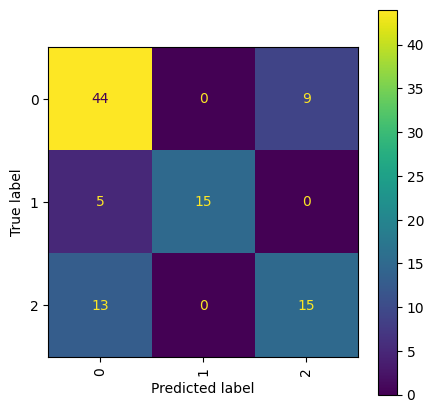

In [ ]:
# Use the model to make predictions on the testset
y_pred_prob = cnn_model2b.predict(X_test)
y_pred  = y_pred_prob.argmax(axis=1)

cm  = confusion_matrix(y_test, y_pred)
cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
cmdisp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")
plt.show()

In [ ]:
from sklearn.metrics  import classification_report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        53
           1       1.00      0.75      0.86        20
           2       0.62      0.54      0.58        28

    accuracy                           0.73       101
   macro avg       0.78      0.71      0.73       101
weighted avg       0.74      0.73      0.73       101



Despite the changes in the model architecture and the class weights, the model performance for Glaucoma remains poor, worse than the original model. This calls for a more sophisticated method for optimizing the model architecture and tuning the hyperparameters.

*Note to self: Check out KerasTuner*

The following functions can be used to plot the accuracy and classification report. Can be useful while optimising the model when the performance needs to be evaluated several times.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_loss(epochs, loss_values, val_loss_values, title='Training and Validation Loss'):
    """
    Plots the training and validation loss over epochs.

    Args:
        epochs: List or array of epoch values.
        loss_values: List or array of training loss values.
        val_loss_values: List or array of validation loss values.
        title: The title of the plot.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, loss_values, 'b', label='Training Loss')
    plt.plot(epochs, val_loss_values, 'r', label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(epochs, accuracy_values, val_accuracy_values, title='Training and Validation Accuracy'):
    """
    Plots the training and validation accuracy over epochs.

    Args:
        epochs: List or array of epoch values.
        accuracy_values: List or array of training accuracy values.
        val_accuracy_values: List or array of validation accuracy values.
        title: The title of the plot.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', cmap='viridis'):
    """
    Plots the confusion matrix.

    Args:
        y_true: The true labels.
        y_pred: The predicted labels.
        title: Title of the plot.
        cmap: Color map for the plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)

    fig, ax = plt.subplots(figsize=(5, 5))
    cmdisp.plot(include_values=True, cmap=cmap, ax=ax, xticks_rotation="vertical")
    plt.title(title)
    plt.show()

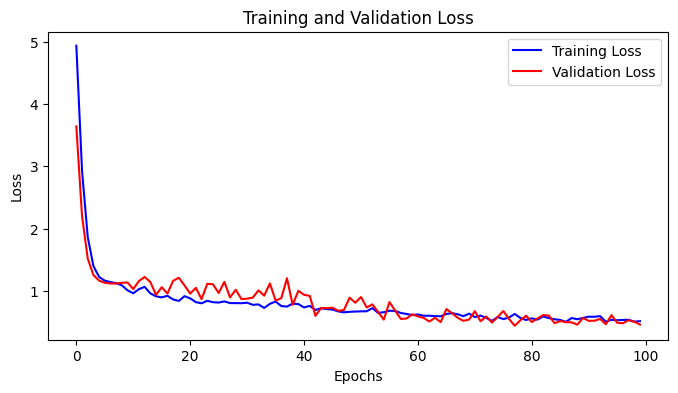

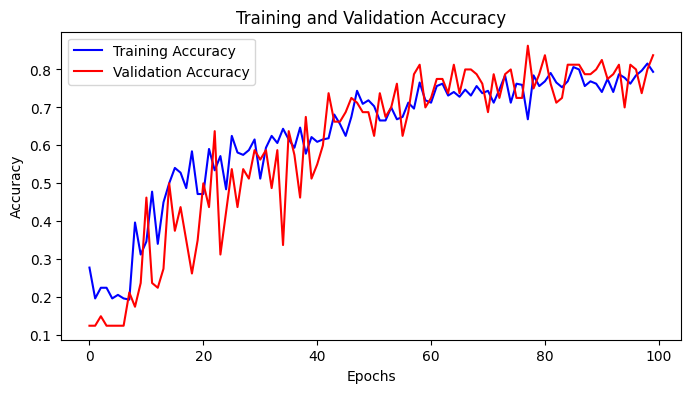

In [ ]:
epochs = history2.epoch
loss_values = history2.history['loss']
val_loss_values = history2.history['val_loss']
accuracy_values = history2.history['accuracy']
val_accuracy_values = history2.history['val_accuracy']

# Plot training and validation loss
plot_loss(epochs, loss_values, val_loss_values)

# Plot training and validation accuracy
plot_accuracy(epochs, accuracy_values, val_accuracy_values)

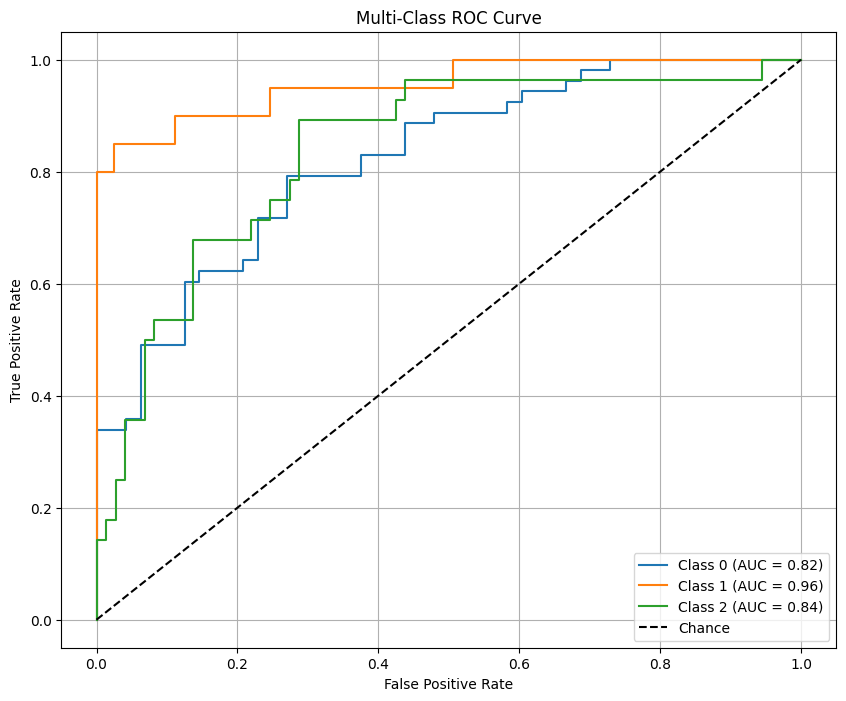

In [ ]:
# Initialize plot
plt.figure(figsize=(10, 8))

# Loop through each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])  # Compute FPR and TPR
    roc_auc = auc(fpr, tpr)  # Compute AUC

    # Plot ROC curve for the current class
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the "chance" line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

# Add labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [19]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/AI_project/Eye_Disease_classification_Model_CustomCNN.ipynb --allow-chromium-download

[NbConvertApp] Converting notebook /content/drive/MyDrive/AI_project/Eye_Disease_classification_Model_CustomCNN.ipynb to pdf
[NbConvertApp] Support files will be in Eye_Disease_classification_Model_CustomCNN_files/
[NbConvertApp] Making directory ./Eye_Disease_classification_Model_CustomCNN_files
[NbConvertApp] Writing 118891 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1666426 bytes to /content/drive/MyDrive/AI_project/Eye_Disease_classification_Model_CustomCNN.pdf
